# Exploratory Data Analysis - Yellow Taxi Trip Data

This notebook explores the yellow taxi trip data from January 2025. We'll look at:
- Time patterns (when do people take taxis?)
- Trip duration analysis
- Location patterns (where do people get picked up and dropped off?)
- Payment and tipping behavior
- Relationships between different variables

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        plt.style.use('default')
sns.set_palette("husl")

## Loading the Data

Let's load the yellow taxi trip data from January 2025.

In [2]:
# Load the data
taxi_trips = pd.read_parquet("../../data/raw/yellow_tripdata_2025-01.parquet")

# Display basic information about the dataset
print(f"Total number of trips: {len(taxi_trips):,}")
print(f"Date range: {taxi_trips['tpep_pickup_datetime'].min()} to {taxi_trips['tpep_pickup_datetime'].max()}")

Total number of trips: 3,475,226
Date range: 2024-12-31 20:47:55 to 2025-02-01 00:00:44


## Time Patterns Analysis

Let's explore when people take taxis. This helps us understand:
- Peak hours (busiest times of day)
- Day of week patterns (weekdays vs weekends)
- How demand changes throughout the day

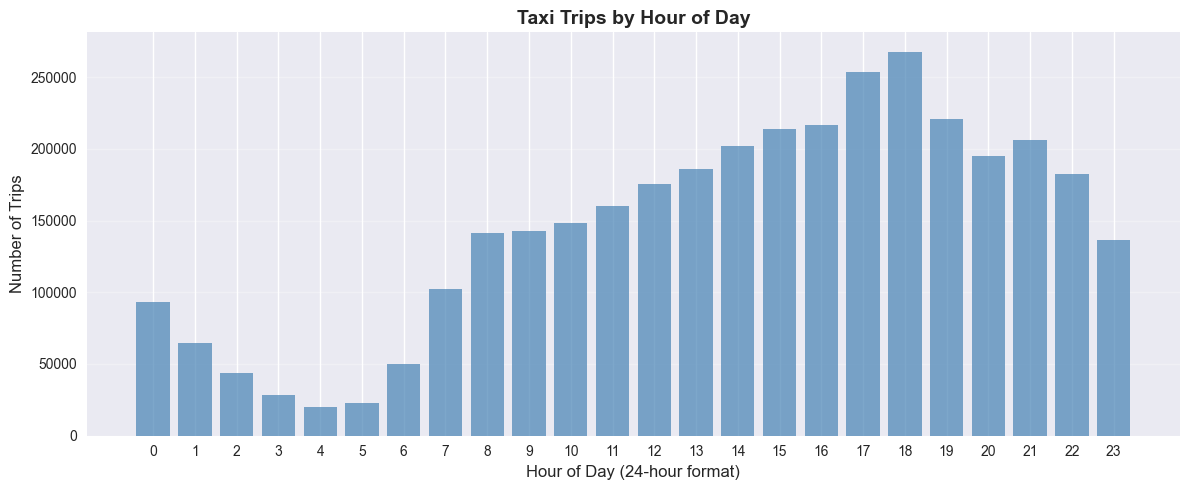


Peak Hours:
Hour 18:00 - 267,951 trips
Hour 17:00 - 253,518 trips
Hour 19:00 - 221,055 trips


In [3]:
# Extract time features from pickup datetime
taxi_trips['pickup_hour'] = taxi_trips['tpep_pickup_datetime'].dt.hour
taxi_trips['pickup_day_of_week'] = taxi_trips['tpep_pickup_datetime'].dt.day_name()
taxi_trips['pickup_date'] = taxi_trips['tpep_pickup_datetime'].dt.date

# Count trips by hour of day
trips_by_hour = taxi_trips['pickup_hour'].value_counts().sort_index()

# Create visualization
plt.figure(figsize=(12, 5))
plt.bar(trips_by_hour.index, trips_by_hour.values, color='steelblue', alpha=0.7)
plt.xlabel('Hour of Day (24-hour format)', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.title('Taxi Trips by Hour of Day', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.xticks(range(24))
plt.tight_layout()
plt.show()

# Print peak hours
peak_hours = trips_by_hour.nlargest(3)
print("\nPeak Hours:")
print("=" * 40)
for hour, count in peak_hours.items():
    print(f"Hour {hour:02d}:00 - {count:,} trips")

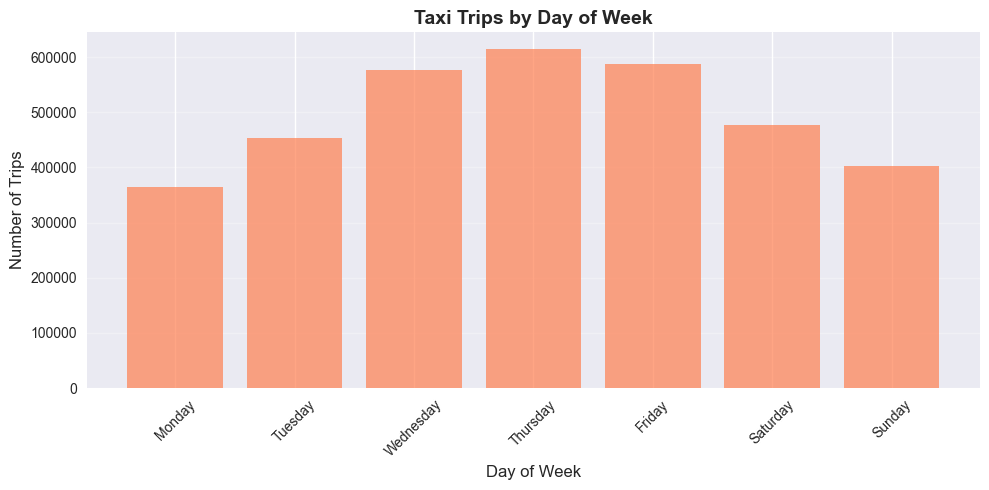


Trips by Day of Week:
Monday      : 363,772 trips
Tuesday     : 453,993 trips
Wednesday   : 577,375 trips
Thursday    : 614,230 trips
Friday      : 586,863 trips
Saturday    : 476,399 trips
Sunday      : 402,594 trips


In [4]:
# Count trips by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
trips_by_day = taxi_trips['pickup_day_of_week'].value_counts().reindex(day_order)

# Create visualization
plt.figure(figsize=(10, 5))
plt.bar(trips_by_day.index, trips_by_day.values, color='coral', alpha=0.7)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.title('Taxi Trips by Day of Week', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary
print("\nTrips by Day of Week:")
print("=" * 40)
for day, count in trips_by_day.items():
    print(f"{day:12s}: {count:,} trips")

## Trip Duration Analysis

Trip duration tells us how long passengers spend in taxis. This is calculated as the difference between pickup and dropoff times.

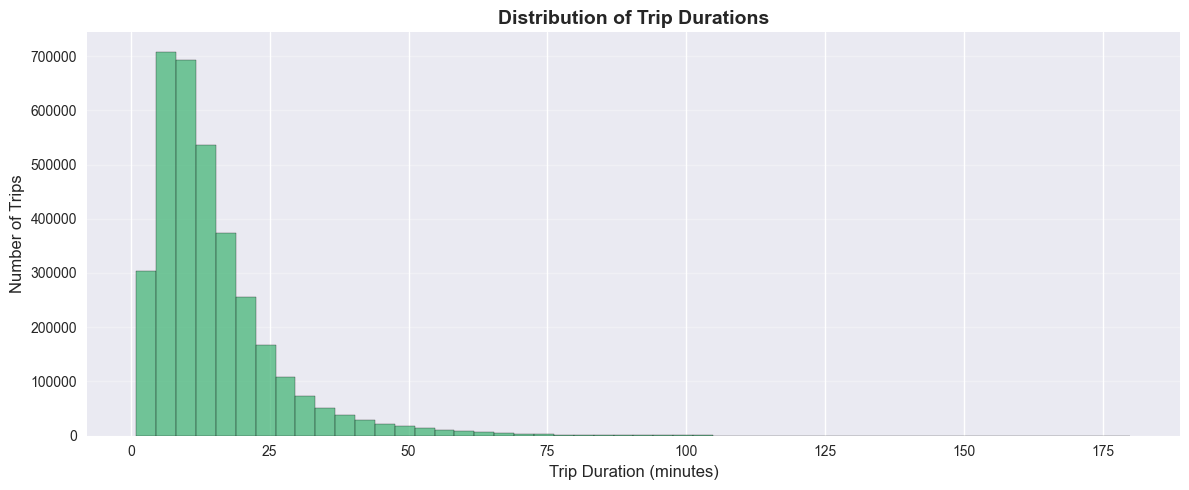


Trip Duration Statistics:
Mean duration:   14.75 minutes
Median duration: 11.82 minutes
Min duration:    1.00 minutes
Max duration:    179.97 minutes

Most common duration range: 9 minutes


In [5]:
# Calculate trip duration in minutes
taxi_trips['trip_duration_minutes'] = (
    (taxi_trips['tpep_dropoff_datetime'] - taxi_trips['tpep_pickup_datetime']).dt.total_seconds() / 60
)

# Remove any unrealistic durations (negative or extremely long trips)
# Filter trips between 1 minute and 3 hours (180 minutes)
valid_durations = taxi_trips[
    (taxi_trips['trip_duration_minutes'] >= 1) & 
    (taxi_trips['trip_duration_minutes'] <= 180)
]['trip_duration_minutes']

# Create histogram
plt.figure(figsize=(12, 5))
plt.hist(valid_durations, bins=50, color='mediumseagreen', alpha=0.7, edgecolor='black')
plt.xlabel('Trip Duration (minutes)', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.title('Distribution of Trip Durations', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics
print("\nTrip Duration Statistics:")
print("=" * 40)
print(f"Mean duration:   {valid_durations.mean():.2f} minutes")
print(f"Median duration: {valid_durations.median():.2f} minutes")
print(f"Min duration:    {valid_durations.min():.2f} minutes")
print(f"Max duration:    {valid_durations.max():.2f} minutes")
print(f"\nMost common duration range: {valid_durations.mode().values[0]:.0f} minutes")

## Location Analysis

Let's see which locations are the most popular for pickups and dropoffs. This helps understand where taxi demand is highest.

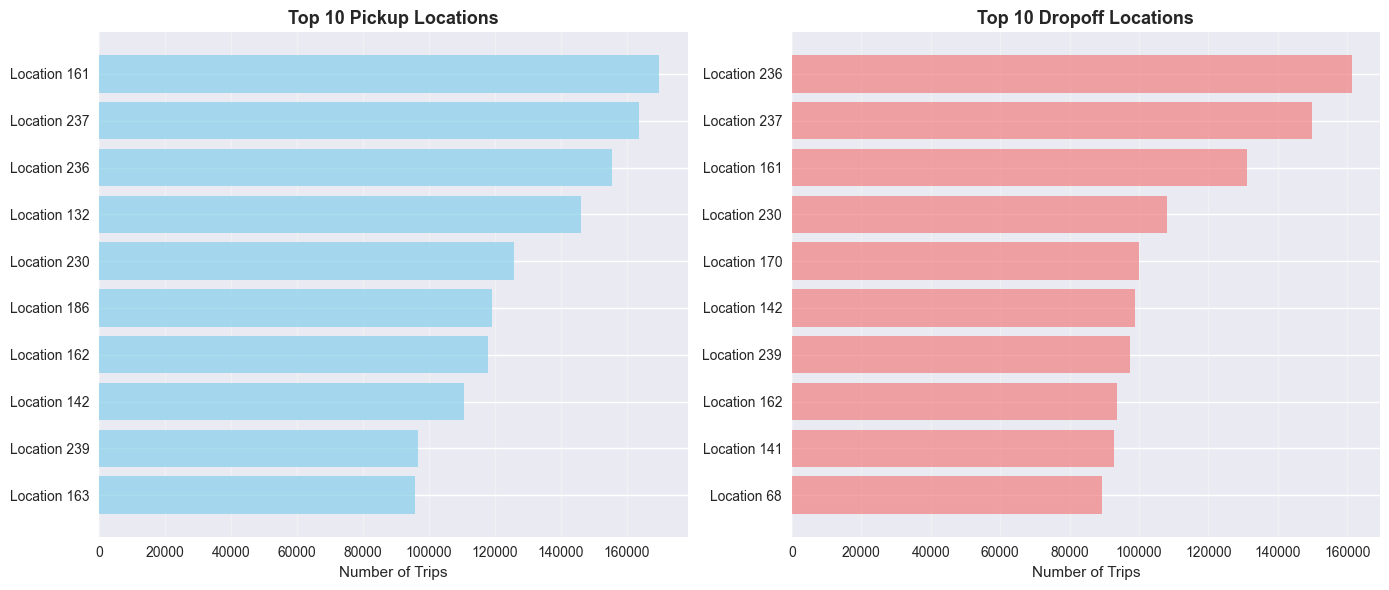


Top 5 Pickup Locations:
Location 161: 169,977 trips
Location 237: 163,703 trips
Location 236: 155,647 trips
Location 132: 146,137 trips
Location 230: 125,829 trips

Top 5 Dropoff Locations:
Location 236: 161,376 trips
Location 237: 149,970 trips
Location 161: 131,258 trips
Location 230: 108,177 trips
Location 170: 100,060 trips


In [6]:
# Find top 10 pickup locations
top_pickup_locations = taxi_trips['PULocationID'].value_counts().head(10)

# Find top 10 dropoff locations
top_dropoff_locations = taxi_trips['DOLocationID'].value_counts().head(10)

# Create side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pickup locations
axes[0].barh(range(len(top_pickup_locations)), top_pickup_locations.values, color='skyblue', alpha=0.7)
axes[0].set_yticks(range(len(top_pickup_locations)))
axes[0].set_yticklabels([f"Location {loc}" for loc in top_pickup_locations.index])
axes[0].set_xlabel('Number of Trips', fontsize=11)
axes[0].set_title('Top 10 Pickup Locations', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Dropoff locations
axes[1].barh(range(len(top_dropoff_locations)), top_dropoff_locations.values, color='lightcoral', alpha=0.7)
axes[1].set_yticks(range(len(top_dropoff_locations)))
axes[1].set_yticklabels([f"Location {loc}" for loc in top_dropoff_locations.index])
axes[1].set_xlabel('Number of Trips', fontsize=11)
axes[1].set_title('Top 10 Dropoff Locations', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Print top locations
print("\nTop 5 Pickup Locations:")
print("=" * 40)
for loc, count in top_pickup_locations.head(5).items():
    print(f"Location {loc:3d}: {count:,} trips")

print("\nTop 5 Dropoff Locations:")
print("=" * 40)
for loc, count in top_dropoff_locations.head(5).items():
    print(f"Location {loc:3d}: {count:,} trips")

## Payment and Tipping Analysis

Understanding how people pay and tip helps us see:
- Preferred payment methods
- Average tip amounts
- Relationship between fare amount and tips

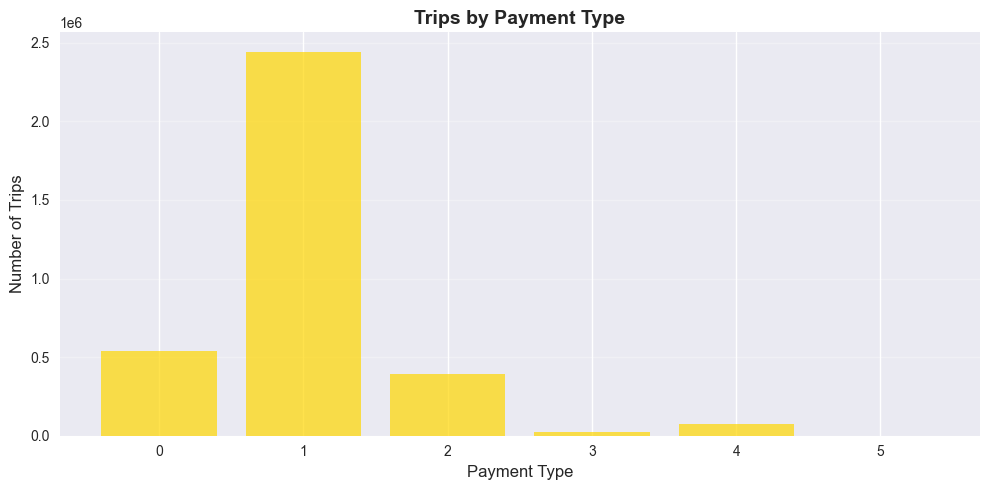


Payment Type Breakdown:
Type 0         :    540,149 trips (15.54%)
Credit Card    :  2,444,393 trips (70.34%)
Cash           :    390,429 trips (11.23%)
No Charge      :     23,773 trips ( 0.68%)
Dispute        :     76,481 trips ( 2.20%)
Unknown        :          1 trips ( 0.00%)


In [7]:
# Payment type analysis
# Common payment types: 1 = Credit card, 2 = Cash, 3 = No charge, 4 = Dispute, 5 = Unknown, 6 = Voided trip
payment_counts = taxi_trips['payment_type'].value_counts().sort_index()

# Create bar chart
plt.figure(figsize=(10, 5))
plt.bar(payment_counts.index.astype(str), payment_counts.values, color='gold', alpha=0.7)
plt.xlabel('Payment Type', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.title('Trips by Payment Type', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print payment type breakdown
print("\nPayment Type Breakdown:")
print("=" * 40)
payment_labels = {1: 'Credit Card', 2: 'Cash', 3: 'No Charge', 4: 'Dispute', 5: 'Unknown', 6: 'Voided Trip'}
for ptype, count in payment_counts.items():
    label = payment_labels.get(ptype, f'Type {ptype}')
    percentage = (count / len(taxi_trips)) * 100
    print(f"{label:15s}: {count:>10,} trips ({percentage:5.2f}%)")

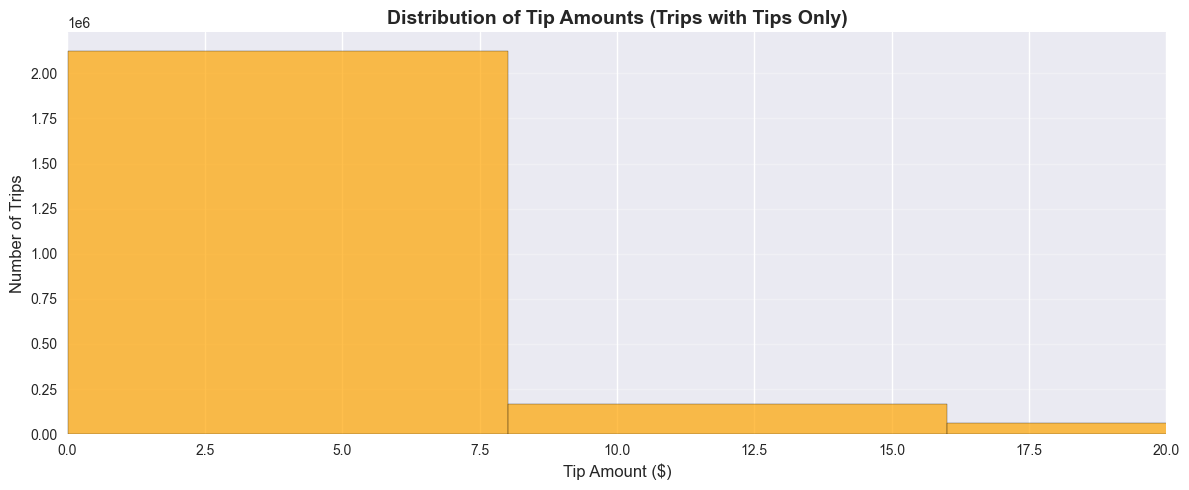


Tip Statistics:
Trips with tips:        2,357,094 (67.83%)
Trips without tips:     1,118,132 (32.17%)

Average tip (when given): $4.36
Median tip (when given): $3.30
Max tip:                $400.00


In [8]:
# Tip analysis - only for trips with tips
trips_with_tips = taxi_trips[taxi_trips['tip_amount'] > 0]

# Create histogram of tip amounts
plt.figure(figsize=(12, 5))
plt.hist(trips_with_tips['tip_amount'], bins=50, color='orange', alpha=0.7, edgecolor='black')
plt.xlabel('Tip Amount ($)', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.title('Distribution of Tip Amounts (Trips with Tips Only)', fontsize=14, fontweight='bold')
plt.xlim(0, 20)  # Focus on tips up to $20 for better visualization
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print tip statistics
print("\nTip Statistics:")
print("=" * 40)
print(f"Trips with tips:        {len(trips_with_tips):,} ({(len(trips_with_tips)/len(taxi_trips)*100):.2f}%)")
print(f"Trips without tips:     {len(taxi_trips) - len(trips_with_tips):,} ({((len(taxi_trips)-len(trips_with_tips))/len(taxi_trips)*100):.2f}%)")
print(f"\nAverage tip (when given): ${trips_with_tips['tip_amount'].mean():.2f}")
print(f"Median tip (when given): ${trips_with_tips['tip_amount'].median():.2f}")
print(f"Max tip:                ${trips_with_tips['tip_amount'].max():.2f}")

## Relationship Between Variables

Let's explore how different variables relate to each other. For example:
- Does trip distance affect the fare amount?
- Is there a relationship between trip duration and distance?
- How does tip amount relate to total fare?

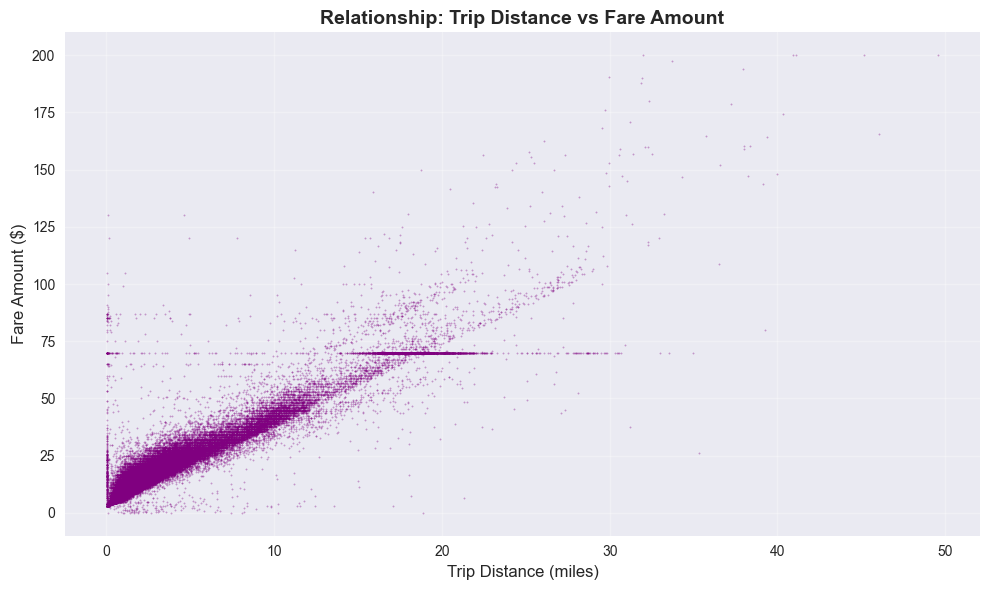


Correlation between trip distance and fare amount: 0.941
(Values closer to 1.0 mean stronger positive relationship)


In [9]:
# Create a sample for faster visualization (use 100,000 random trips)
sample_size = min(100000, len(taxi_trips))
sample_trips = taxi_trips.sample(n=sample_size, random_state=42)

# Filter out unrealistic values for better visualization
sample_trips_clean = sample_trips[
    (sample_trips['trip_distance'] > 0) & 
    (sample_trips['trip_distance'] <= 50) &
    (sample_trips['fare_amount'] > 0) & 
    (sample_trips['fare_amount'] <= 200)
]

# Scatter plot: Trip Distance vs Fare Amount
plt.figure(figsize=(10, 6))
plt.scatter(sample_trips_clean['trip_distance'], sample_trips_clean['fare_amount'], 
            alpha=0.3, s=1, color='purple')
plt.xlabel('Trip Distance (miles)', fontsize=12)
plt.ylabel('Fare Amount ($)', fontsize=12)
plt.title('Relationship: Trip Distance vs Fare Amount', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate correlation
correlation = sample_trips_clean['trip_distance'].corr(sample_trips_clean['fare_amount'])
print(f"\nCorrelation between trip distance and fare amount: {correlation:.3f}")
print("(Values closer to 1.0 mean stronger positive relationship)")

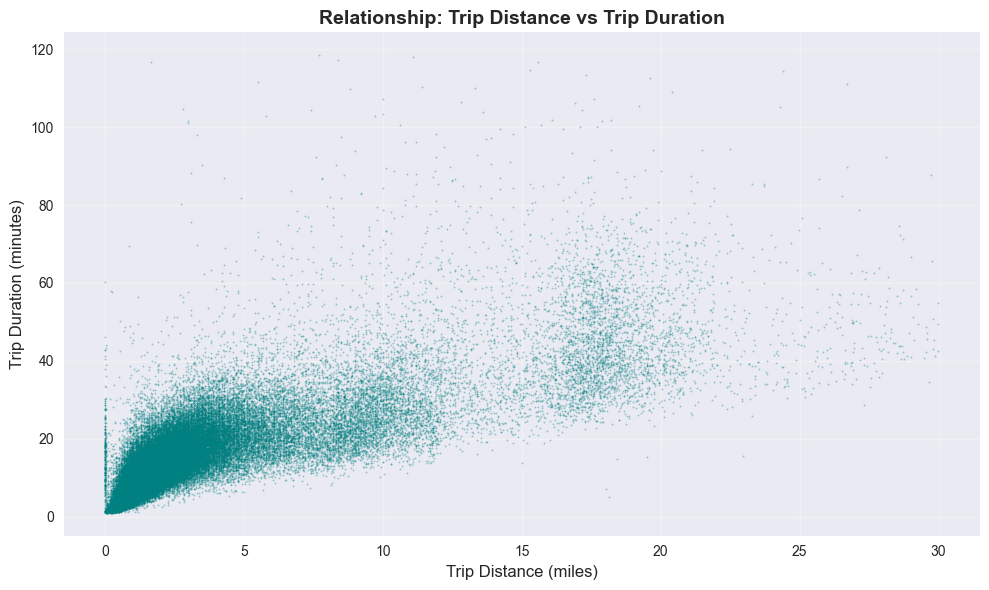


Correlation between trip distance and duration: 0.803


In [10]:
# Scatter plot: Trip Duration vs Trip Distance
# Use the sample and filter for valid durations
sample_duration = sample_trips[
    (sample_trips['trip_duration_minutes'] >= 1) & 
    (sample_trips['trip_duration_minutes'] <= 120) &
    (sample_trips['trip_distance'] > 0) & 
    (sample_trips['trip_distance'] <= 30)
]

plt.figure(figsize=(10, 6))
plt.scatter(sample_duration['trip_distance'], sample_duration['trip_duration_minutes'], 
            alpha=0.3, s=1, color='teal')
plt.xlabel('Trip Distance (miles)', fontsize=12)
plt.ylabel('Trip Duration (minutes)', fontsize=12)
plt.title('Relationship: Trip Distance vs Trip Duration', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate correlation
correlation = sample_duration['trip_distance'].corr(sample_duration['trip_duration_minutes'])
print(f"\nCorrelation between trip distance and duration: {correlation:.3f}")

## Cost Breakdown Analysis

Let's see how the total fare is made up of different components (base fare, tips, taxes, surcharges, etc.)

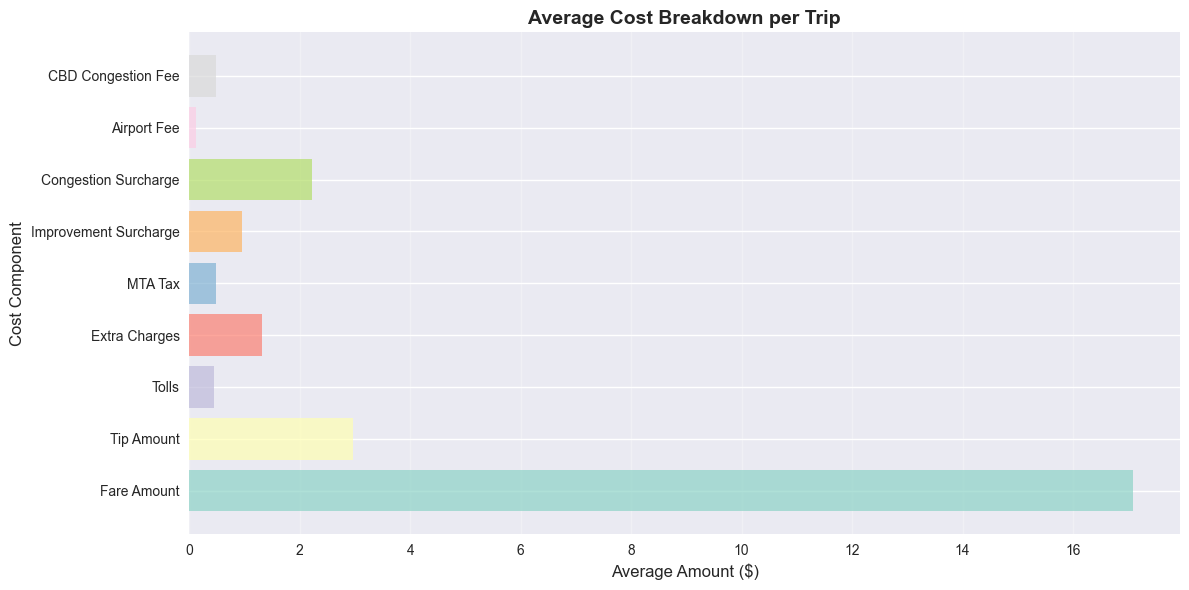


Average Cost Breakdown per Trip:
Fare Amount              : $   17.08
Tip Amount               : $    2.96
Tolls                    : $    0.45
Extra Charges            : $    1.32
MTA Tax                  : $    0.48
Improvement Surcharge    : $    0.95
Congestion Surcharge     : $    2.23
Airport Fee              : $    0.12
CBD Congestion Fee       : $    0.48

Total Amount             : $   25.61


In [11]:
# Calculate average amounts for each cost component
cost_components = {
    'Fare Amount': taxi_trips['fare_amount'].mean(),
    'Tip Amount': taxi_trips['tip_amount'].mean(),
    'Tolls': taxi_trips['tolls_amount'].mean(),
    'Extra Charges': taxi_trips['extra'].mean(),
    'MTA Tax': taxi_trips['mta_tax'].mean(),
    'Improvement Surcharge': taxi_trips['improvement_surcharge'].mean(),
    'Congestion Surcharge': taxi_trips['congestion_surcharge'].mean(),
    'Airport Fee': taxi_trips['Airport_fee'].mean(),
    'CBD Congestion Fee': taxi_trips['cbd_congestion_fee'].mean()
}

# Create bar chart
plt.figure(figsize=(12, 6))
components = list(cost_components.keys())
amounts = list(cost_components.values())
colors = plt.cm.Set3(range(len(components)))

plt.barh(components, amounts, color=colors, alpha=0.7)
plt.xlabel('Average Amount ($)', fontsize=12)
plt.ylabel('Cost Component', fontsize=12)
plt.title('Average Cost Breakdown per Trip', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Print breakdown
print("\nAverage Cost Breakdown per Trip:")
print("=" * 50)
for component, amount in cost_components.items():
    print(f"{component:25s}: ${amount:>8.2f}")
print(f"\n{'Total Amount':25s}: ${taxi_trips['total_amount'].mean():>8.2f}")

## Summary

This analysis revealed several interesting patterns:
- **Peak hours**: Most trips occur during rush hours (morning and evening)
- **Day patterns**: Weekdays tend to have more trips than weekends
- **Trip duration**: Most trips are relatively short (under 30 minutes)
- **Locations**: Certain locations are much more popular than others
- **Payment**: Credit cards are the most common payment method
- **Tips**: A significant portion of trips include tips
- **Relationships**: Trip distance and fare amount are strongly correlated

These insights can help with:
- Resource allocation (scheduling more taxis during peak hours)
- Understanding customer behavior
- Identifying high-demand areas
- Pricing strategies